# Problem 1.

## Plot Adiabatic Flame Temperature (H2/O2, HP case)

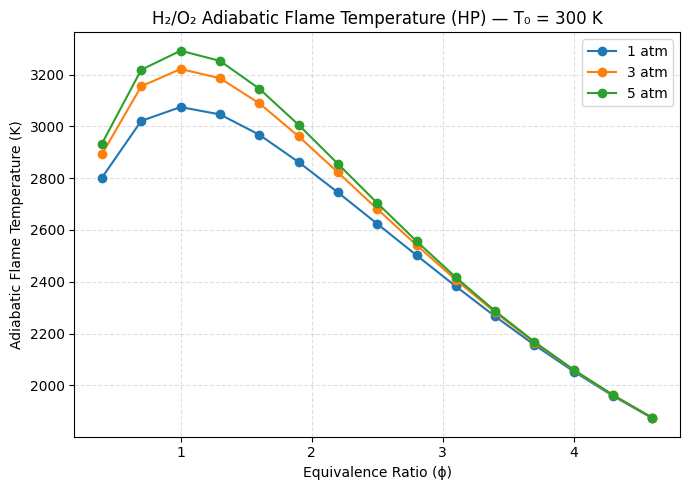

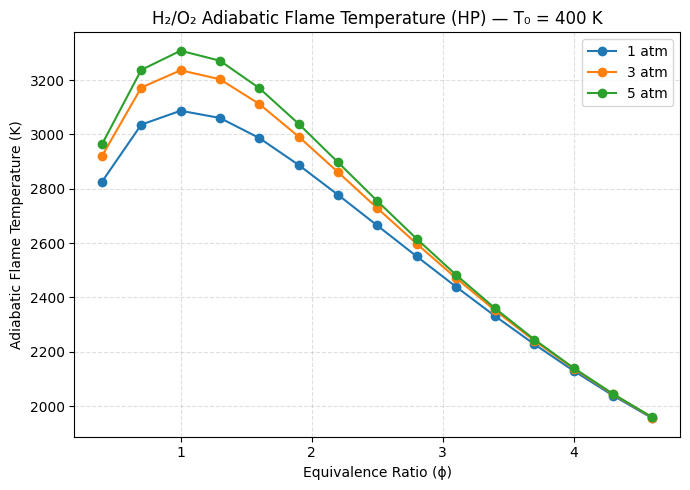

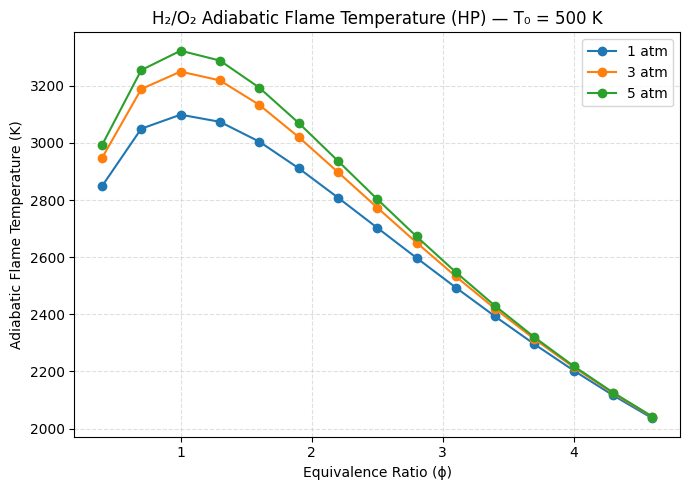

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume 'prob1_data' DataFrame already exists or load from CSV
# Columns: T0_K, phi, P_atm, Tad_K
# If you already saved it:
prob1_data = pd.read_csv("prob1_H2O2_Tad_table.csv")

# Plot: one chart per initial temperature
for T0 in [300, 400, 500]:
    dfT = prob1_data[prob1_data["T0_K"] == T0].sort_values(["phi", "P_atm"])
    plt.figure(figsize=(7, 5))
    for P in [1, 3, 5]:
        sub = dfT[dfT["P_atm"] == P]
        plt.plot(sub["phi"], sub["Tad_K"], marker='o', label=f"{P} atm")

    plt.xlabel("Equivalence Ratio (ϕ)")
    plt.ylabel("Adiabatic Flame Temperature (K)")
    plt.title(f"H₂/O₂ Adiabatic Flame Temperature (HP) — T₀ = {T0} K")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"prob1_Tad_vs_phi_T0_{T0}K.png", dpi=200)
    plt.show()


## Combined Plot: Adiabatic Flame Temperature (Problem 1)

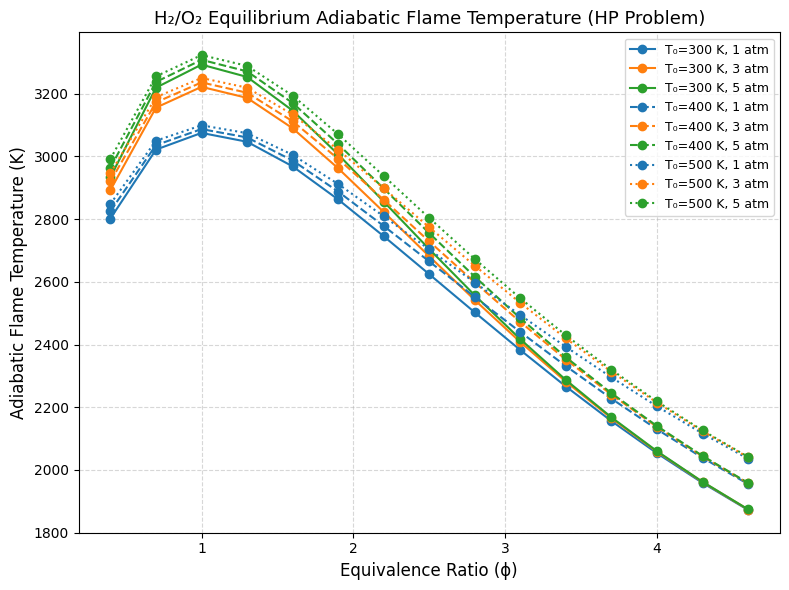

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your tidy table if not already loaded
# prob1_data = pd.read_csv("prob1_H2O2_Tad_table.csv")

# Define colors and line styles to distinguish conditions
colors = {1: 'tab:blue', 3: 'tab:orange', 5: 'tab:green'}
linestyles = {300: '-', 400: '--', 500: ':'}

plt.figure(figsize=(8,6))

for T0 in [300, 400, 500]:
    for P in [1, 3, 5]:
        df_sub = prob1_data[(prob1_data["T0_K"] == T0) & (prob1_data["P_atm"] == P)].sort_values("phi")
        if df_sub.empty:
            continue
        plt.plot(
            df_sub["phi"], df_sub["Tad_K"],
            color=colors[P],
            linestyle=linestyles[T0],
            marker='o',
            label=f"T₀={T0} K, {P} atm"
        )

plt.xlabel("Equivalence Ratio (ϕ)", fontsize=12)
plt.ylabel("Adiabatic Flame Temperature (K)", fontsize=12)
plt.title("H₂/O₂ Equilibrium Adiabatic Flame Temperature (HP Problem)", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9, loc='best')
plt.tight_layout()
plt.savefig("prob1_H2O2_Tad_combined.png", dpi=200)
plt.show()


# Problem 2: H2/Air Frozen Calculations (NASA CEA)
## Parser + Plots

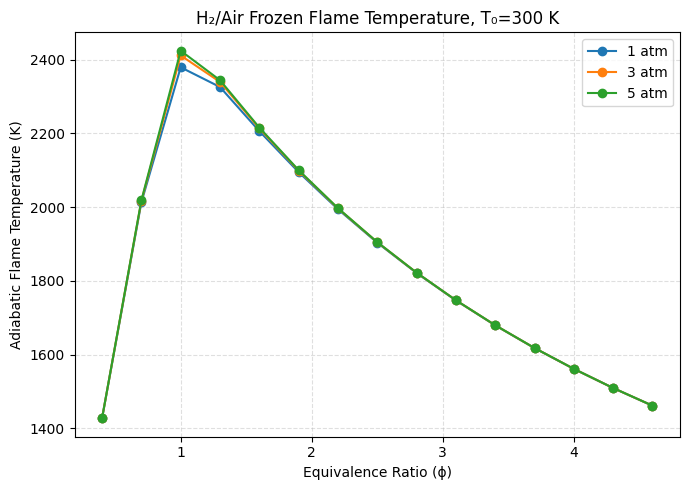

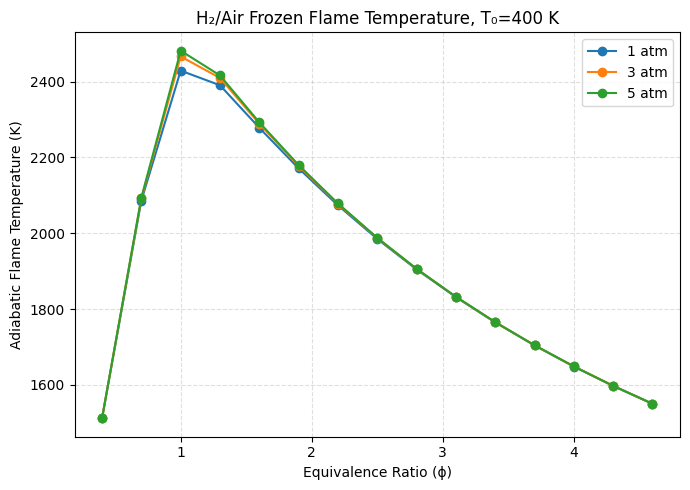

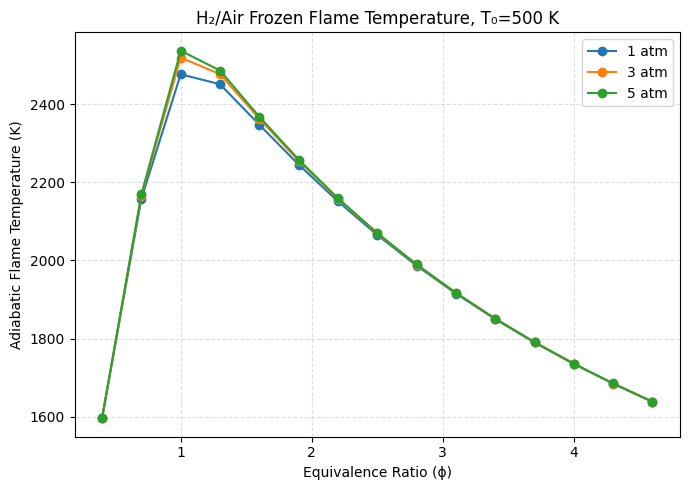

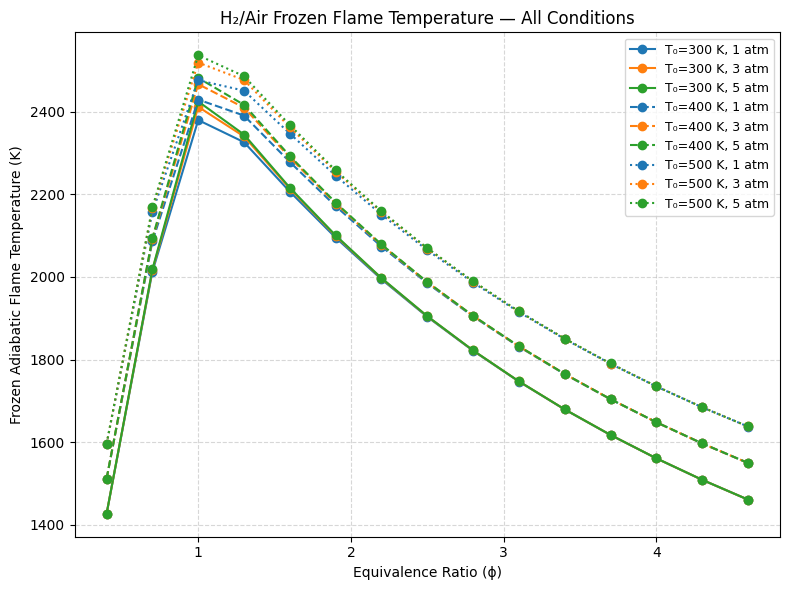

In [3]:
# ---------------------------------------------------
# Problem 2 (H2/Air, Frozen): robust parser + plots
# ---------------------------------------------------
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


files = {
    300: "prob2_300k_output.txt",
    400: "prob2_400k_output.txt",
    500: "prob2_500k_output.txt",
}

def parse_cea_frozen_blocks(path):
    """
    Parse NASA CEA output for 'frozen' runs where, for each PHI,
    multiple CHAMBER/THROAT/EXIT tables appear (one per pressure).
    Extract CHAMBER pressure (P,BAR first column) and CHAMBER T (T,K first column).
    Map pressure (bar) to nearest of {1,3,5} atm using 1 atm = 1.01325 bar.
    """
    text = Path(path).read_text(errors="ignore")
    rows = []

    # Find all PHI blocks
    phi_iter = list(re.finditer(r"PHI,EQ\.RATIO=\s*([0-9.]+)", text))
    for i, m in enumerate(phi_iter):
        phi = float(m.group(1))
        start = m.end()
        end = phi_iter[i+1].start() if i+1 < len(phi_iter) else len(text)
        block = text[start:end]

        # Within this φ-block, iterate over each CHAMBER/THROAT/EXIT table
        for sect in re.finditer(r"CHAMBER\s+THROAT\s+EXIT(.*?)(?=CHAMBER\s+THROAT\s+EXIT|$)", block, flags=re.S):
            tbl = sect.group(1)

            # Grab P, BAR line and T, K line
            p_line = re.search(r"P,\s*BAR\s+([0-9Ee+\-.\s]+)", tbl)
            t_line = re.search(r"T,\s*K\s+([0-9Ee+\-.\s]+)", tbl)
            if not (p_line and t_line):
                continue

            # First column = CHAMBER
            def first_float(s):
                nums = re.findall(r"[-+]?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?", s.strip())
                return float(nums[0]) if nums else None

            P_bar = first_float(p_line.group(1))
            T_chamber = first_float(t_line.group(1))
            if P_bar is None or T_chamber is None:
                continue

            # Map bar → nearest of {1,3,5} atm
            P_atm_exact = P_bar / 1.01325
            P_atm = min([1,3,5], key=lambda x: abs(P_atm_exact - x))

            rows.append((phi, P_atm, T_chamber))

    df = pd.DataFrame(rows, columns=["phi", "P_atm", "Tad_K"]).drop_duplicates(["phi", "P_atm"])
    return df.sort_values(["phi", "P_atm"])

# --- Parse all files and plot ---
all_records = []
for T0, path in files.items():
    df = parse_cea_frozen_blocks(path)
    df["T0_K"] = T0
    all_records.append(df)
problem2_data = pd.concat(all_records, ignore_index=True)

# Optional: save to CSV to sanity-check
problem2_data.sort_values(["T0_K","P_atm","phi"]).to_csv("prob2_H2air_frozen_Tad_table.csv", index=False)

# 1) One plot per T0
for T0 in [300, 400, 500]:
    dfT = problem2_data[problem2_data["T0_K"] == T0].sort_values(["phi","P_atm"])
    plt.figure(figsize=(7,5))
    for P in [1,3,5]:
        sub = dfT[dfT["P_atm"]==P]
        plt.plot(sub["phi"], sub["Tad_K"], marker='o', label=f"{P} atm")
    plt.xlabel("Equivalence Ratio (ϕ)")
    plt.ylabel("Adiabatic Flame Temperature (K)")
    plt.title(f"H₂/Air Frozen Flame Temperature, T₀={T0} K")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"prob2_Frozen_Tad_vs_phi_T0_{T0}K.png", dpi=200)
    plt.show()

# 2) Combined figure (all T0 and P)
colors = {1: 'tab:blue', 3: 'tab:orange', 5: 'tab:green'}
linestyles = {300: '-', 400: '--', 500: ':'}

plt.figure(figsize=(8,6))
for T0 in [300, 400, 500]:
    for P in [1, 3, 5]:
        sub = problem2_data[(problem2_data["T0_K"]==T0) & (problem2_data["P_atm"]==P)].sort_values("phi")
        if sub.empty: 
            continue
        plt.plot(sub["phi"], sub["Tad_K"],
                 color=colors[P], linestyle=linestyles[T0],
                 marker='o', label=f"T₀={T0} K, {P} atm")
plt.xlabel("Equivalence Ratio (ϕ)")
plt.ylabel("Frozen Adiabatic Flame Temperature (K)")
plt.title("H₂/Air Frozen Flame Temperature — All Conditions")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig("prob2_Frozen_Tad_combined.png", dpi=200)
plt.show()


# Problem 3 (CH4/Air)
## HP parser + plots
### Parses NASA CEA "Assigned Enthalpy & Pressure" outputs and plots Adiabatic Flame Temperature vs equivalence ratio.

Saved: prob3_CH4air_HP_Tad.csv


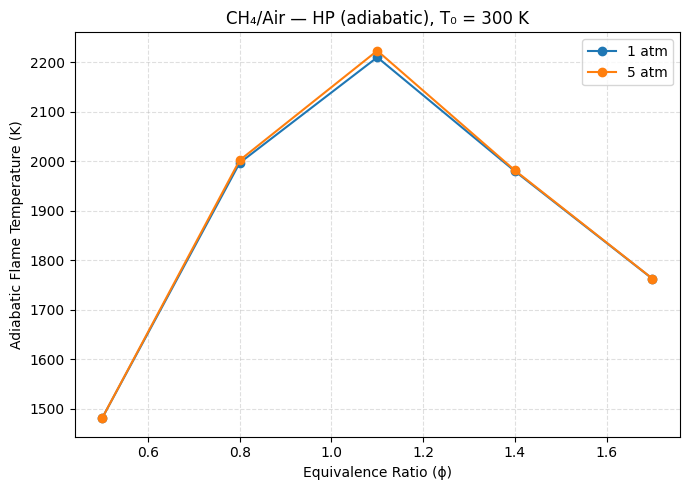

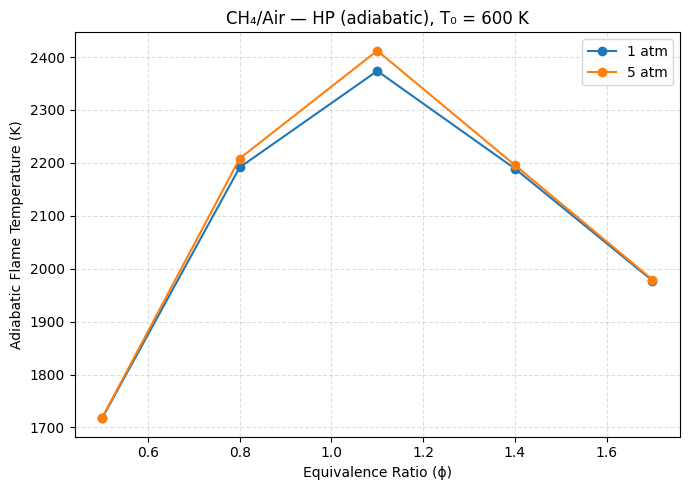

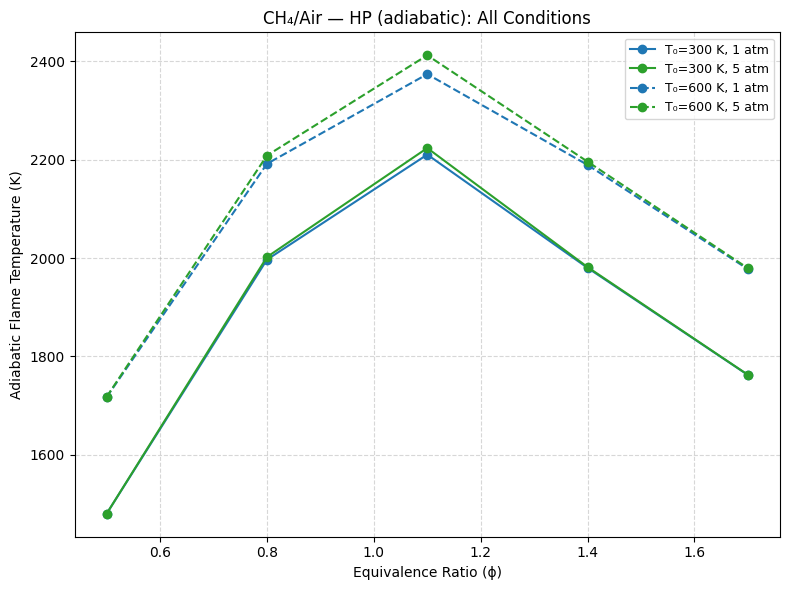

In [4]:
# ---------------------------------------------------
# Problem 3 (CH4/Air) — HP parser + plots
# Parses NASA CEA "Assigned Enthalpy & Pressure" outputs
# and plots Adiabatic Flame Temperature vs equivalence ratio.
# ---------------------------------------------------

import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---- point these to your files ----
hp_files = {
    300: "prob3_hp_300k_output.txt",   # T0 = 300 K HP run (P=1 & 5 atm)
    600: "prob3_hp_600k_output.txt",   # T0 = 600 K HP run (P=1 & 5 atm)
}

def parse_hp_file(path):
    """
    Parse a CEA HP output file.
    For each PHI block, read the 'THERMODYNAMIC PROPERTIES' table, and
    extract CHAMBER pressure (P,BAR first number) and CHAMBER temperature (T,K first number).
    Map pressure in bar -> nearest of {1, 5} atm using 1 atm = 1.01325 bar.
    Returns DataFrame with columns: phi, P_atm, Tad_K
    """
    text = Path(path).read_text(errors="ignore")
    rows = []

    # Find each PHI block
    phi_iter = list(re.finditer(r"PHI,EQ\.RATIO=\s*([0-9.]+)", text))
    for i, m in enumerate(phi_iter):
        phi = float(m.group(1))
        start = m.end()
        end = phi_iter[i+1].start() if i+1 < len(phi_iter) else len(text)
        block = text[start:end]

        # Inside the phi-block, grab the first "THERMODYNAMIC PROPERTIES" table
        # (HP prints a single table with columns for the specified pressures)
        m_prop = re.search(r"THERMODYNAMIC PROPERTIES(.*?)MASS FRACTIONS", block, flags=re.S)
        if not m_prop:
            # fallback: stop at a blank line/end if MASS FRACTIONS header not present
            m_prop = re.search(r"THERMODYNAMIC PROPERTIES(.*?)(?:\n\s*\n|\Z)", block, flags=re.S)
        if not m_prop:
            continue
        tbl = m_prop.group(1)

        # Extract CHAMBER column values for P and T
        def floats(s):  # robust float grabber
            return [float(x) for x in re.findall(r"[-+]?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?", s)]

        p_line = re.search(r"\bP,\s*BAR\s+([0-9Ee+\-.\s]+)", tbl)
        t_line = re.search(r"\bT,\s*K\s+([0-9Ee+\-.\s]+)", tbl)
        if not (p_line and t_line):
            continue

        pbar_cols = floats(p_line.group(1))
        t_cols    = floats(t_line.group(1))
        if len(pbar_cols) < 2 or len(t_cols) < 2:
            # Expecting at least two columns (1 atm and 5 atm)
            continue

        # Pair up columns by order. We only need the CHAMBER values (= first number in each row),
        # which CEA already gives as the first number in the list.
        # Map bar -> nearest of {1,5} atm
        for bar, Tflame in zip(pbar_cols[:2], t_cols[:2]):
            P_atm = 1 if abs(bar/1.01325 - 1) < 0.5 else 5
            rows.append((phi, P_atm, Tflame))

    df = pd.DataFrame(rows, columns=["phi", "P_atm", "Tad_K"]).drop_duplicates(["phi", "P_atm"])
    return df.sort_values(["phi", "P_atm"])

# ---- parse all HP files, tag by T0, save CSV ----
hp_records = []
for T0, fpath in hp_files.items():
    df = parse_hp_file(fpath)
    df["T0_K"] = T0
    hp_records.append(df)

hp_full = pd.concat(hp_records, ignore_index=True).sort_values(["T0_K","phi","P_atm"])
hp_full.to_csv("prob3_CH4air_HP_Tad.csv", index=False)
print("Saved: prob3_CH4air_HP_Tad.csv")

# ---- make plots: one per T0, P=1 & 5 atm curves ----
for T0 in sorted(hp_full["T0_K"].unique()):
    d = hp_full[hp_full["T0_K"] == T0].sort_values(["phi","P_atm"])
    plt.figure(figsize=(7,5))
    for P in [1, 5]:
        sub = d[d["P_atm"] == P]
        if sub.empty: 
            continue
        plt.plot(sub["phi"], sub["Tad_K"], marker='o', label=f"{P} atm")
    plt.xlabel("Equivalence Ratio (ϕ)")
    plt.ylabel("Adiabatic Flame Temperature (K)")
    plt.title(f"CH₄/Air — HP (adiabatic), T₀ = {T0} K")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"prob3_HP_Tad_vs_phi_T0_{T0}K.png", dpi=200)
    plt.show()

# ---- optional: single combined figure (all T0 & P) ----
colors = {1: 'tab:blue', 5: 'tab:green'}
linestyles = {300: '-', 600: '--'}

plt.figure(figsize=(8,6))
for T0 in sorted(hp_full["T0_K"].unique()):
    for P in [1, 5]:
        sub = hp_full[(hp_full["T0_K"]==T0) & (hp_full["P_atm"]==P)].sort_values("phi")
        if sub.empty: 
            continue
        plt.plot(sub["phi"], sub["Tad_K"],
                 color=colors[P], linestyle=linestyles[T0],
                 marker='o', label=f"T₀={T0} K, {P} atm")
plt.xlabel("Equivalence Ratio (ϕ)")
plt.ylabel("Adiabatic Flame Temperature (K)")
plt.title("CH₄/Air — HP (adiabatic): All Conditions")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig("prob3_HP_Tad_combined.png", dpi=200)
plt.show()


## Problem 3: CH4/Air — TP parser

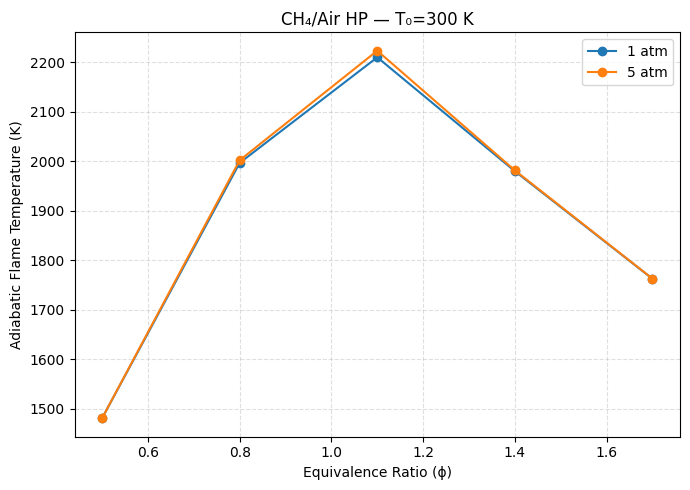

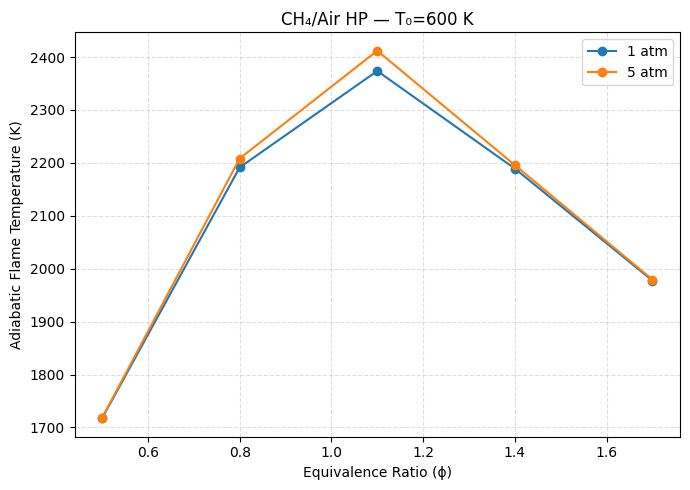

In [5]:
# -------------------------------
# Problem 3: CH4/Air — TP parser
# -------------------------------
import re, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

tp_path = "prob3_tp_300_600_output.txt"  # update if needed
text = Path(tp_path).read_text(errors="ignore")

rows = []
# One PHI block at a time
for mphi in re.finditer(r"PHI,EQ\.RATIO=\s*([0-9.]+)", text):
    phi = float(mphi.group(1))
    block = text[mphi.end():]
    # stop at next PHI
    next_m = re.search(r"PHI,EQ\.RATIO=", block)
    if next_m: block = block[:next_m.start()]

    # Inside this phi-block, scan all "THERMODYNAMIC PROPERTIES" tables
    for sect in re.finditer(r"THERMODYNAMIC PROPERTIES(.*?)(?:MASS FRACTIONS|PRODUCTS WHICH WERE CONSIDERED|\Z)",
                            block, flags=re.S):
        tbl = sect.group(1)
        # Pull T, P, H rows (two columns = 1 atm, 5 atm)
        def floats(s): return [float(x) for x in re.findall(r"[-+]?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?", s)]
        t_line = re.search(r"\bT,\s*K\s+([0-9Ee+\-.\s]+)", tbl)
        p_line = re.search(r"\bP,\s*BAR\s+([0-9Ee+\-.\s]+)", tbl)
        h_line = re.search(r"\bH,\s*KJ/KG\s+([0-9Ee+\-.\s]+)", tbl)
        if not (t_line and p_line and h_line): 
            continue
        Ts  = floats(t_line.group(1))
        Ps  = floats(p_line.group(1))
        Hs  = floats(h_line.group(1))
        if len(Ps) >= 2 and len(Hs) >= 2 and len(Ts) >= 1:
            T_here = round(Ts[0],2)
            for bar, H in zip(Ps[:2], Hs[:2]):
                P_atm = 1 if abs(bar/1.01325 - 1) < 0.5 else 5
                rows.append((T_here, phi, P_atm, H))

tp = pd.DataFrame(rows, columns=["T_K","phi","P_atm","H_kJ_per_kg"]).drop_duplicates(["T_K","phi","P_atm"])
tp = tp.sort_values(["T_K","phi","P_atm"])
tp.to_csv("prob3_CH4air_TP_H.csv", index=False)

# --- Quick plots ---
# HP: Tad vs phi (use the CSV I made earlier)
hp = pd.read_csv("prob3_CH4air_HP_Tad.csv")

for T0 in [300, 600]:
    d = hp[hp["T0_K"]==T0].sort_values(["phi","P_atm"])
    plt.figure(figsize=(7,5))
    for P in [1,5]:
        sub = d[d["P_atm"]==P]
        plt.plot(sub["phi"], sub["Tad_K"], marker='o', label=f"{P} atm")
    plt.xlabel("Equivalence Ratio (ϕ)")
    plt.ylabel("Adiabatic Flame Temperature (K)")
    plt.title(f"CH₄/Air HP — T₀={T0} K")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"prob3_HP_Tad_vs_phi_T0_{T0}K.png", dpi=200)
    plt.show()


Saved CSV: prob3_CH4air_TP_H_combined.csv


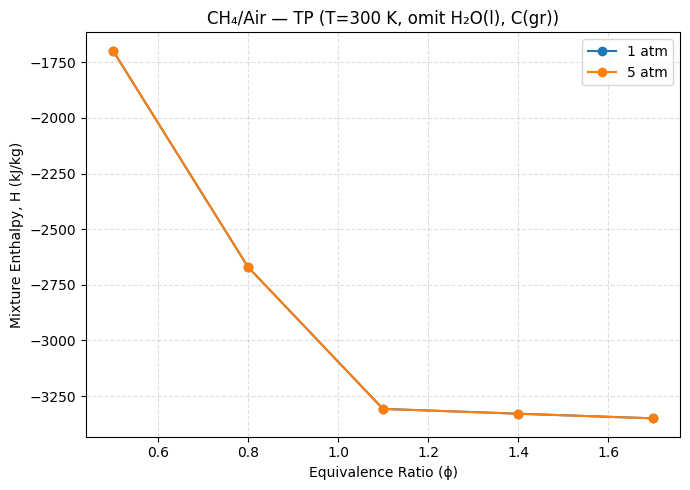

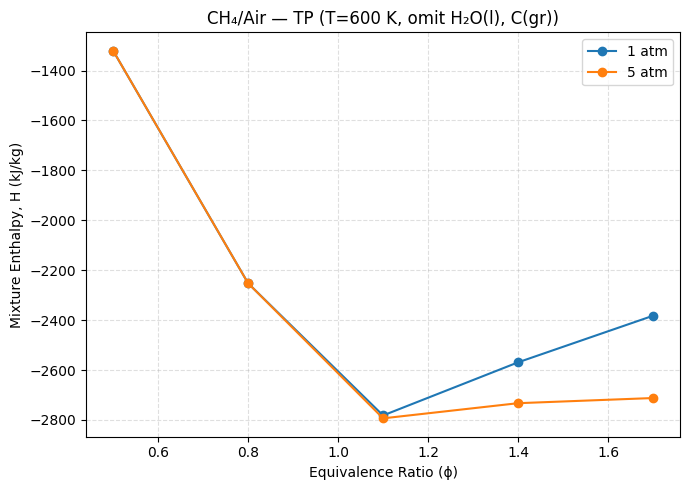

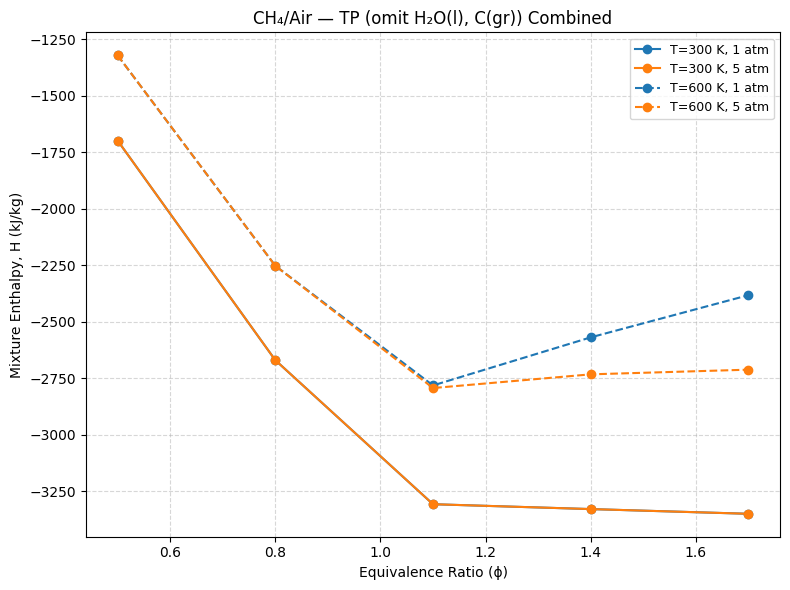

In [6]:
# ---------------------------------------------------
# Problem 3 (CH4/Air, TP): parse + plot (+ combined plot)
# ---------------------------------------------------

import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

tp_files = {
    300: "prob3_tp_300k_omit_h20lcgr.txt",
    600: "prob3_tp_600k_omit_h20lcgr.txt",
}

def parse_tp_file(path):
    text = Path(path).read_text(errors="ignore")
    rows = []
    phi_iter = list(re.finditer(r"PHI,EQ\.RATIO=\s*([0-9.]+)", text))
    for i, m in enumerate(phi_iter):
        phi = float(m.group(1))
        start = m.end()
        end = phi_iter[i+1].start() if i+1 < len(phi_iter) else len(text)
        block = text[start:end]

        m_prop = re.search(r"THERMODYNAMIC PROPERTIES(.*?)MASS FRACTIONS", block, flags=re.S)
        if not m_prop:
            m_prop = re.search(r"THERMODYNAMIC PROPERTIES(.*?)(?:\n\s*\n|\Z)", block, flags=re.S)
        if not m_prop:
            continue
        tbl = m_prop.group(1)

        def floats(s): return [float(x) for x in re.findall(r"[-+]?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?", s)]

        p_line = re.search(r"\bP,\s*BAR\s+([0-9Ee+\-.\s]+)", tbl)
        h_line = re.search(r"\bH,\s*KJ/KG\s+([0-9Ee+\-.\s]+)", tbl)
        if not (p_line and h_line):
            continue
        pbar_cols = floats(p_line.group(1))
        h_cols    = floats(h_line.group(1))
        if len(pbar_cols) < 2 or len(h_cols) < 2:
            continue

        for bar, H in zip(pbar_cols[:2], h_cols[:2]):
            P_atm = 1 if abs(bar/1.01325 - 1) < abs(bar/1.01325 - 5) else 5
            rows.append((phi, P_atm, H))

    df = pd.DataFrame(rows, columns=["phi","P_atm","H_kJ_per_kg"]).drop_duplicates(["phi","P_atm"])
    return df.sort_values(["phi","P_atm"])

# ----- Combine all files -----
tp_records = []
for T in [300, 600]:
    df = parse_tp_file(tp_files[T])
    df["T_K"] = T
    tp_records.append(df)

tp_full = pd.concat(tp_records, ignore_index=True).sort_values(["T_K","phi","P_atm"])
tp_full.to_csv("prob3_CH4air_TP_H_combined.csv", index=False)
print("Saved CSV: prob3_CH4air_TP_H_combined.csv")

# ----- Individual plots -----
for T in [300, 600]:
    d = tp_full[tp_full["T_K"] == T]
    plt.figure(figsize=(7,5))
    for P in [1, 5]:
        sub = d[d["P_atm"] == P].sort_values("phi")
        plt.plot(sub["phi"], sub["H_kJ_per_kg"], marker='o', label=f"{P} atm")
    plt.xlabel("Equivalence Ratio (ϕ)")
    plt.ylabel("Mixture Enthalpy, H (kJ/kg)")
    plt.title(f"CH₄/Air — TP (T={T} K, omit H₂O(l), C(gr))")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"prob3_TP_H_vs_phi_T_{T}K_final.png", dpi=200)
    plt.show()

# ----- Combined plot (all conditions) -----
colors = {1: "tab:blue", 5: "tab:orange"}
linestyles = {300: "-", 600: "--"}

plt.figure(figsize=(8,6))
for T in [300, 600]:
    for P in [1, 5]:
        sub = tp_full[(tp_full["T_K"]==T) & (tp_full["P_atm"]==P)].sort_values("phi")
        if sub.empty:
            continue
        plt.plot(sub["phi"], sub["H_kJ_per_kg"],
                 color=colors[P], linestyle=linestyles[T],
                 marker='o', label=f"T={T} K, {P} atm")
plt.xlabel("Equivalence Ratio (ϕ)")
plt.ylabel("Mixture Enthalpy, H (kJ/kg)")
plt.title("CH₄/Air — TP (omit H₂O(l), C(gr)) Combined")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig("prob3_TP_H_combined.png", dpi=200)
plt.show()



# Problem 4.


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 8.009e-06  log(ss)= 4.882     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0001368  log(ss)= 3.325     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.003507   log(ss)= 3.37      

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 5.852e-05  log(ss)= 4.813     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 3.906e-06  log(ss)= 7.183     

Attempt Newton solution 

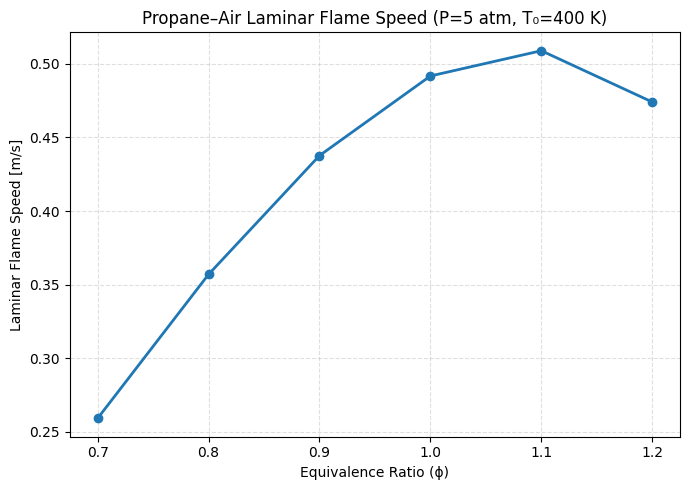

In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- parameters ---
phi_values = np.arange(0.7, 1.21, 0.1)
P = 5 * ct.one_atm
T_in = 400  # K
gas = ct.Solution("gri30.yaml")

flame_speeds = []
prev_flame = None  # for continuation (speeds up successive runs)

for phi in phi_values:
    gas.set_equivalence_ratio(phi, "C3H8", "O2:1.0, N2:3.76")
    gas.TP = T_in, P

    flame = ct.FreeFlame(gas, width=0.03)  # narrower domain
    flame.set_refine_criteria(ratio=3, slope=0.05, curve=0.1)
    flame.transport_model = "mixture-averaged"  # updated keyword

    if prev_flame is not None:
        flame.set_initial_guess(data=prev_flame.to_array())  # reuse previous solution

    flame.solve(loglevel=1, auto=True)
    prev_flame = flame

    flame_speeds.append(flame.velocity[0])
    print(f"phi={phi:.2f}, S_L={flame.velocity[0]:.3f} m/s")

# --- save & plot ---
df = pd.DataFrame({"phi": phi_values, "S_L_m_per_s": flame_speeds})
df.to_csv("prob4_flame_speed.csv", index=False)

plt.figure(figsize=(7,5))
plt.plot(df["phi"], df["S_L_m_per_s"], "o-", lw=2)
plt.xlabel("Equivalence Ratio (ϕ)")
plt.ylabel("Laminar Flame Speed [m/s]")
plt.title("Propane–Air Laminar Flame Speed (P=5 atm, T₀=400 K)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("prob4_propane_flame_speed.png", dpi=200)
plt.show()


# Problem 5.

/tmp/ipykernel_4976/1070070796.py:18: UserWarning: Kinetics::checkDuplicates: 
*******************************************************************************
InputFileError thrown by Kinetics::checkDuplicates:
Error on lines 2773 and 2871 of ./dme.yaml:
Undeclared duplicate third body reactions with a common third body detected.
Add the field 'explicit-third-body-duplicates: mark-duplicate' or
'explicit-third-body-duplicates: modify-efficiency' to the YAML phase entry
to choose how these reactions should be handled and suppress this warning.
Reaction 586: hco2h + oh => co + h2o + oh
Reaction 633: hco2h + M => co + h2o + M

|  Line |
|  2768 |   rate-constant: {A: 4.5e+15, b: -1.1, Ea: 0.0}
|  2769 | - equation: hoch2o => hco2h + h  # Reaction 584
|  2770 |   rate-constant: {A: 1.0e+14, b: 0.0, Ea: 1.49e+04}
|  2771 | - equation: hco2h + h => hoch2o  # Reaction 585
|  2772 |   rate-constant: {A: 5.904e+11, b: 0.64, Ea: 9214.0}
>  2773 > - equation: hco2h + M => co + h2o + M  # Reaction

Mechanism: dme.yaml, fuel='ch3och3'
T0=800.0 K  ->  tau_CV=0.133037 s,  tau_CP=0.178713 s
T0=850.0 K  ->  tau_CV=0.112466 s,  tau_CP=0.140421 s
T0=900.0 K  ->  tau_CV=0.0989705 s,  tau_CP=0.116498 s
T0=950.0 K  ->  tau_CV=0.0780893 s,  tau_CP=0.0889693 s
T0=1000.0 K  ->  tau_CV=0.0453005 s,  tau_CP=0.0514848 s
T0=1050.0 K  ->  tau_CV=0.0203065 s,  tau_CP=0.0234558 s
T0=1100.0 K  ->  tau_CV=0.00822132 s,  tau_CP=0.00972083 s
T0=1150.0 K  ->  tau_CV=0.00329076 s,  tau_CP=0.00399083 s
T0=1200.0 K  ->  tau_CV=0.00136274 s,  tau_CP=0.00169577 s
T0=1250.0 K  ->  tau_CV=0.000598842 s,  tau_CP=0.00076488 s
T0=1300.0 K  ->  tau_CV=0.000283485 s,  tau_CP=0.000371766 s
T0=1350.0 K  ->  tau_CV=0.00014569 s,  tau_CP=0.000196151 s
T0=1400.0 K  ->  tau_CV=8.13953e-05 s,  tau_CP=0.000112427 s
Saved: prob5_DME_ignition_delays.csv


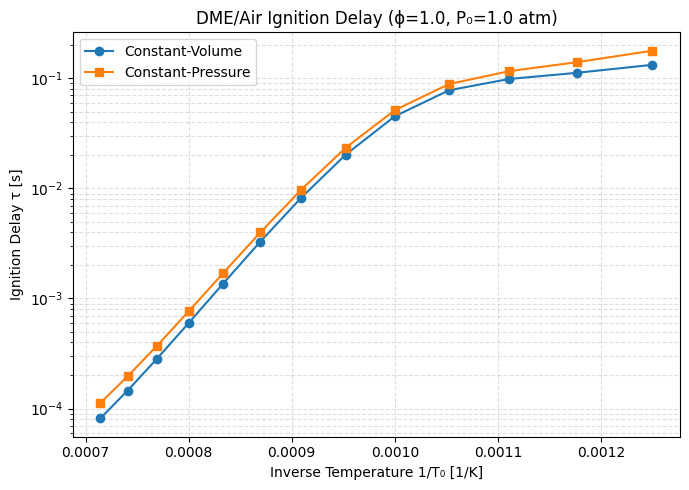

In [2]:
# ------------------------------------------------------------
# Problem 5: DME/Air ignition delay (CV vs CP) using Cantera
# Requires: dme.yaml (converted from LLNL CHEMKIN)
# ------------------------------------------------------------
import cantera as ct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MECH_FILE = "dme.yaml"     # produced by ck2yaml
P0 = 1.0 * ct.one_atm # change to 5 if NaN at low T
phi = 1.0
T_min, T_max, dT = 800.0, 1400.0, 50.0
# Allow more time at low T; you can raise this if 800–900 K doesn’t ignite
max_time_map = [(0, 0.5), (900, 0.2), (1100, 0.05), (1300, 0.02)]  # (T_threshold, max_time s)
rtol, atol = 1e-9, 1e-15

gas = ct.Solution(MECH_FILE)

# Detect DME species name
fuel_candidates = ["ch3och3", "CH3OCH3", "DME"]
fuel = next((s for s in fuel_candidates if s in gas.species_names), None)
if fuel is None:
    raise ValueError(f"Could not find a DME species among {fuel_candidates} in {MECH_FILE}")

air = "O2:1.0, N2:3.76"

def set_phi_TP(g, phi_val, T0, P0):
    g.set_equivalence_ratio(phi_val, fuel=fuel, oxidizer=air)
    g.TP = T0, P0

def pick_max_time(T0):
    mt = max_time_map[0][1]
    for thr, val in max_time_map:
        if T0 >= thr: mt = val
    return mt

def ignition_delay(times, temps):
    dTdt = np.gradient(temps, times, edge_order=2)
    k = np.argmax(dTdt)
    return times[k], k

def run_one(T0, is_cp):
    g = ct.Solution(MECH_FILE)
    set_phi_TP(g, phi, T0, P0)
    r = ct.IdealGasConstPressureReactor(g) if is_cp else ct.IdealGasReactor(g)
    sim = ct.ReactorNet([r])
    sim.rtol = rtol; sim.atol = atol

    t_final = pick_max_time(T0)
    t = 0.0
    times, temps = [], []
    while t < t_final:
        t = sim.step()
        times.append(t); temps.append(r.T)
        # early stop: large temp jump → take a few extra steps and stop
        if len(times) > 5 and temps[-1] - temps[0] > 1000:
            for _ in range(5):
                t = sim.step(); times.append(t); temps.append(r.T)
            break

    times = np.array(times); temps = np.array(temps)
    if len(times) < 5 or (temps.max() - temps[0]) < 10:
        return np.nan
    tau, _ = ignition_delay(times, temps)
    return tau

T_list = np.arange(T_min, T_max + 1e-9, dT)
rows = []
print(f"Mechanism: {MECH_FILE}, fuel='{fuel}'")
for T0 in T_list:
    tau_cv = run_one(T0, is_cp=False)
    tau_cp = run_one(T0, is_cp=True)
    rows.append((T0, 1.0/T0, tau_cv, tau_cp))
    print(f"T0={T0:.1f} K  ->  tau_CV={tau_cv:.6g} s,  tau_CP={tau_cp:.6g} s")

df = pd.DataFrame(rows, columns=["T0_K", "invT_1perK", "tau_CV_s", "tau_CP_s"])
df.to_csv("prob5_DME_ignition_delays.csv", index=False)
print("Saved: prob5_DME_ignition_delays.csv")

plt.figure(figsize=(7,5))
plt.semilogy(df["invT_1perK"], df["tau_CV_s"], "o-", label="Constant-Volume")
plt.semilogy(df["invT_1perK"], df["tau_CP_s"], "s-", label="Constant-Pressure")
plt.xlabel("Inverse Temperature 1/T₀ [1/K]")
plt.ylabel("Ignition Delay τ [s]")
plt.title(f"DME/Air Ignition Delay (ϕ={phi:.1f}, P₀={P0/ct.one_atm:.1f} atm)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig("prob5_DME_tau_vs_invT.png", dpi=200)
plt.show()
